In [78]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular
from tqdm import tqdm

In [79]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [80]:
import os
files = os.listdir("dataset")

import csv

class Route:
    def __init__(self, phi, v, M, IMU_v, IMU_alpha):
        self.phi = phi
        self.v = v
        self.M = M
        self.IMU_v = IMU_v
        self.IMU_alpha = IMU_alpha
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

maxVDot = [0]*3
maxAlphaDot = [0]*3
for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = []
        v = []
        M = []
        IMU_v = []
        IMU_alpha = []
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            M.append(float(row[3]))
            
            vPacket = [float(row[i]) for i in range(4, 7)]
            alphaPacket = [float(row[i]) for i in range(7, 10)]
            IMU_v.append(vPacket)
            IMU_alpha.append(alphaPacket)
            
            maxAngle = max(abs(float(row[1])), maxAngle)
            maxSpeed = max(abs(float(row[2])), maxSpeed)
            maxTorque = max(abs(float(row[3])), maxTorque)
            
            for i in range(3):
                maxVDot[i] = max(abs(float(row[4+i])), maxVDot[i])
                maxAlphaDot[i] = max(abs(float(row[7+i])), maxAlphaDot[i])
        routes.append(Route(torch.tensor(phi), torch.tensor(v), torch.tensor(M), torch.tensor(IMU_v).permute(1,0), torch.tensor(IMU_alpha).permute(1,0)))
        allRows += len(phi)


print(allRows)
print(maxAngle, maxSpeed, maxTorque, maxVDot, maxAlphaDot)

673988
41.70000076293945 39.09857177734375 1.0 [19.161849975585938, 8.428146362304688, 11.452590942382812] [0.18414306640625, 0.8147430419921875, 0.1421051025390625]


In [81]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

prev_data = 300
fwd_data = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


all_routes = len(routes)
print(f"{all_routes} routes")
test_count = int(all_routes*0.2)
test_routes_id = [randrange(all_routes) for _ in range(test_count)]
# test_routes_id = [46, 66, 3, 26, 37, 84, 33, 59, 33, 31, 65, 73, 56, 54, 18, 25, 58]

train_routes = [routes[i] for i in range(all_routes) if i not in test_routes_id]
test_routes = [routes[i] for i in range(all_routes) if i in test_routes_id]
#Phi, v, M, IMU_v, IMU_alpha
groups = [4, 20, 20, 20, 20]

input_length = prev_data//groups[0] + prev_data//groups[1] + (prev_data+fwd_data[-1])//groups[2] + 3*prev_data//groups[3] + 3*prev_data//groups[4]
output_length = len(fwd_data)

def caddy_dataset(train):
    i_data = []
    o_data = []
    routes = train_routes if train else test_routes
    for route in tqdm(routes):
        for idx in range(prev_data, len(route.v)-fwd_data[-1], 5):
            phi = route.phi[idx-prev_data : idx]/maxAngle
            v = route.v[idx-prev_data : idx]/maxSpeed
            M = route.M[idx-prev_data : idx+fwd_data[-1]]/maxTorque
            
            phi = phi.reshape(-1, groups[0]).mean(axis=1)
            v = v.reshape(-1, groups[1]).mean(axis=1)
            M = M.reshape(-1, groups[2]).mean(axis=1)
            
            IMU_v = [(route.IMU_v[i][idx-prev_data:idx]/maxVDot[i]).reshape(-1, groups[3]).mean(axis=1) for i in range(3)]
            IMU_alpha = [(route.IMU_alpha[i][idx-prev_data:idx]/maxAlphaDot[i]).reshape(-1, groups[4]).mean(axis=1) for i in range(3)]
            
            o = torch.zeros((output_length,))
            for i in range(output_length):
                o[i] = route.phi[idx+fwd_data[i]]/maxAngle
            data = (phi, v, M, IMU_v[0], IMU_v[1], IMU_v[2], IMU_alpha[0], IMU_alpha[1], IMU_alpha[2])
            data_input = np.concatenate(data)
            i_data.append(data_input)
            o_data.append(o)
    return SimDataset(len(i_data), i_data, o_data)


train_set = caddy_dataset(True)
test_set = caddy_dataset(False)

print(len(train_set), len(test_set), test_routes_id)

  1%|▏         | 1/71 [00:00<00:12,  5.77it/s]

86 routes


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]

99920 28033 [26, 75, 82, 8, 48, 23, 67, 43, 24, 10, 1, 2, 63, 68, 1, 8, 29]


In [82]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False)
print(len(train_dataloader))
print(len(test_dataloader))

1561
439


In [83]:
# base_size = prev_data//group_base
# IMU_size = prev_data//group_IMU
# torque_size = (prev_data + fwd_data)//group_base
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_length, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_length),
            nn.Tanh()
        )

        
    def forward(self, x):
        return self.linear_relu_stack(x)
print(input_length)

200


In [85]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if debug:
        loss = loss.item()*100
        print(f"Train loss: {loss}")
    return loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()*100

    test_loss /= num_batches
    print(f"Test  loss: {test_loss} \n")
    return test_loss

model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

torch.Size([64, 200])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
17674


Epoch 0
Train loss: 2.437698468565941
Test  loss: 1.9871003488778796 

Epoch 1
Train loss: 1.582198217511177
Test  loss: 1.4373057828431182 

Epoch 2
Train loss: 1.1969384737312794
Test  loss: 1.246987870132767 

Epoch 3
Train loss: 1.154832448810339
Test  loss: 1.1468810274887296 

Epoch 4
Train loss: 1.0927519761025906
Test  loss: 1.083870753348892 

Epoch 5
Train loss: 0.9381706826388836
Test  loss: 1.0314321716619415 

Epoch 6
Train loss: 1.5670191496610641
Test  loss: 0.9987439760293362 

Epoch 7
Train loss: 1.0524556040763855
Test  loss: 0.9611693686107704 

Epoch 8
Train loss: 1.3405360281467438
Test  loss: 0.935275348567389 

Epoch 9
Train loss: 1.1566286906599998
Test  loss: 0.9095439247167532 

Epoch 10
Train loss: 0.7505989633500576
Test  loss: 0.8894666617021287 

Epoch 11
Train loss: 0.9555066004395485
Test  loss: 0.8737290082372097 

Epoch 12
Train loss: 1.09779117628932
Test  loss: 0.8574485326406455 

Epoch 13
Train loss: 0.9351386688649654
Test  loss: 0.845531747858878

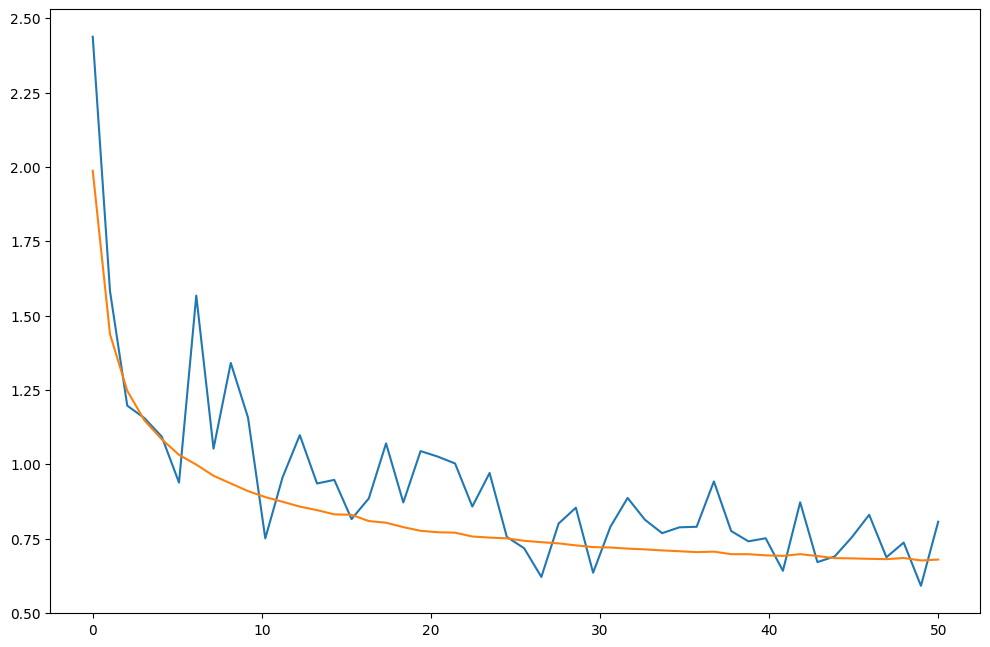

In [86]:
epochs = 50
skip = 1
loss_t = []
loss_e = []
for t in range(epochs):
    if t%skip == 0:
        print(f"Epoch {t}")
    loss_t.append(train_loop(train_dataloader, model, loss_fn, optimizer, t%skip==0))
    if t%skip == 0:
        loss_e.append(test_loop(test_dataloader, model, loss_fn))

plt.plot(np.linspace(0, epochs, epochs), loss_t)
plt.plot(np.linspace(0, epochs, epochs), loss_e)

-2.2499999662874615 initial angle
tensor([-2.2500, -2.2500, -2.2500, -2.2500, -2.2500, -2.2500, -2.2500, -2.1000,
        -2.1000, -2.1000])
tensor([-2.2501, -2.1715, -2.1596, -2.2055, -2.1882, -2.1614, -2.1319, -2.1274,
        -2.0396, -1.9604], grad_fn=<MulBackward0>)


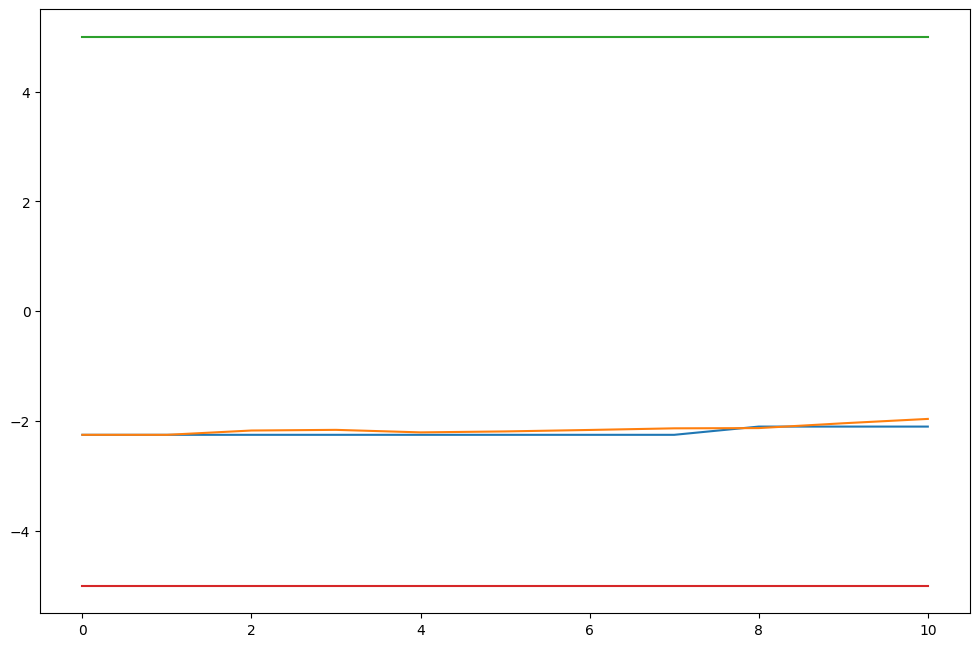

In [125]:
random_sample = test_set[randrange(len(test_set))]
initial_angle = random_sample[0][prev_data//groups[0]-1]*maxAngle
print(initial_angle, "initial angle")
print(random_sample[1]*maxAngle)

torch_data_input = torch.from_numpy(random_sample[0])
torch_data_output = model(torch_data_input)*maxAngle
print(torch_data_output)

ls_good = [initial_angle] +[random_sample[1][i]*maxAngle for i in range(output_length)]
ls_pred = [initial_angle] +[torch_data_output[i] for i in range(output_length)]

plt.plot(np.linspace(0, output_length, output_length+1), ls_good)
plt.plot(np.linspace(0, output_length, output_length+1), ls_pred)
plt.plot(np.linspace(0, output_length, output_length+1), np.ones((output_length+1,))*5)
plt.plot(np.linspace(0, output_length, output_length+1), np.ones((output_length+1,))*-5)

In [126]:
torch.save(model, 'model_L1Norm.pth')